The example was inspired by Patrick Kidgers PHD Thesis (https://arxiv.org/abs/2202.02435) and the code was adapted from https://github.com/rtqichen/torchdiffeq (ode_demo.py)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

In [24]:
# true ODE of the system

def f_true(t, y):
    rabbits, cats = y
    # true parameters
    a, b, c, d = [2, 0.5, 0.5, 0.1]
    
    # some arbitrary additional terms added to the standard model
    d_rabbits_dt = a * rabbits - b * rabbits * cats     - 0.5 * np.log(rabbits) 
    d_cats_dt = -c * cats + d * rabbits * cats          + 0.1 * cats * np.log(rabbits) 
    
    return np.array([d_rabbits_dt, d_cats_dt])

y_0 = [2.,1.]

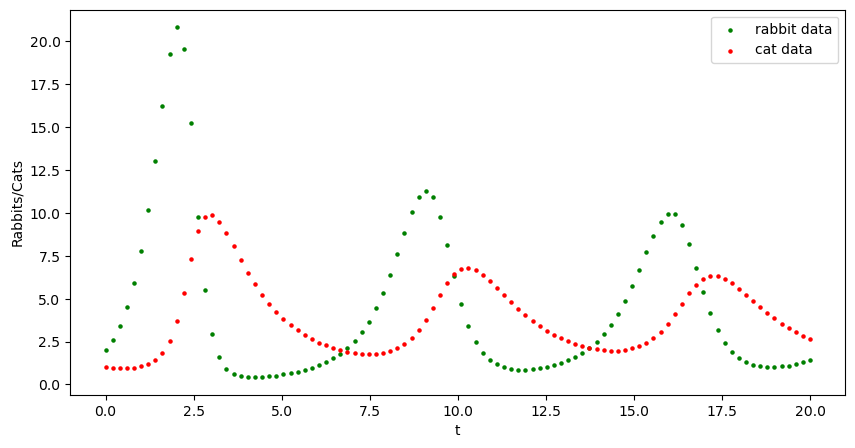

In [25]:
# generate some data from the true ODE
t_data = np.linspace(0, 20, 100)
sol_true = odeint(f_true, y_0, t_data, tfirst = True)
plt.figure(figsize = (10,5)) 
plt.scatter(t_data, sol_true[:,0], label = "rabbit data", color = "green", s = 5)
plt.scatter(t_data, sol_true[:,1], label = "cat data", color = "red", s = 5)
plt.xlabel("t")
plt.ylabel("Rabbits/Cats")
plt.legend()
plt.show()

In [26]:
# define the model we know but is incomplete

def f_model(t, y, params):
    rabbits, cats = y
    a, b, c, d = params
    
    d_rabbits_dt = a * rabbits - b * rabbits * cats
    d_cats_dt = -c * cats + d * rabbits * cats
    
    return np.array([d_rabbits_dt, d_cats_dt])

In [27]:
def integrate(t, a, b, c, d):
    params = ([a, b, c, d], )
    result = odeint(f_model, y_0, t, args = params, tfirst = True)
    return np.concatenate((result[:,0], result[:,1]))

# fit the known ODE to the data
popt, pcov = curve_fit(integrate, t_data, np.concatenate((sol_true[:,0], sol_true[:,1])), p0 = [2,0.5,0.5,0.1])
print("parameters from fit:", popt)

[1.57021182 0.47619362 0.68436824 0.17330377]


In [28]:
# solve ODE with the determined parameters
t_plot = np.linspace(0,20,1000)
sol = odeint(f_model, y_0, t_plot, args = (popt, ), tfirst = True)

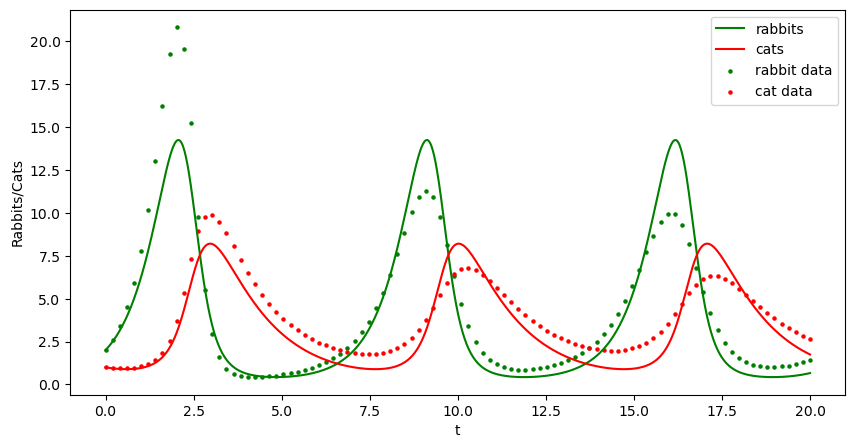

In [9]:
plt.figure(figsize = (10,5))
plt.plot(t_plot, sol[:,0], label = "rabbits", color = "green")
plt.plot(t_plot, sol[:,1], label = "cats", color = "red")
plt.scatter(t_data, sol_true[:,0], label = "rabbit data", color = "green", s = 5)
plt.scatter(t_data, sol_true[:,1], label = "cat data", color = "red", s = 5)
plt.xlabel("t")
plt.ylabel("Rabbits/Cats")
plt.legend()
plt.show()

# Add NN to model

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchdiffeq import odeint_adjoint

In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_size = len(t_data) #100
batch_time = 20
batch_size = 20
niters = 500

NameError: name 'torch' is not defined

In [ ]:
true_y = torch.tensor(sol_true).reshape(len(t_data), 1, 2)
t_data = torch.tensor(t_data)
t_plot = torch.tensor(t_plot)

In [52]:
def get_batch():
    # draw "batch_size" number of samples without replacement. These are indeces.
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    
    # get the data at these indeces. They will be starting values for the integration.
    batch_y0 = true_y[s]  # (M, D)
    
    # get first batch_time values from the time linspace t
    batch_t = t_data[:batch_time]  # (T)
    
    # start at the batch_y0s and add the next batch_time elements from the true y trajectory.
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# define ODE with added NNs
class ODEFunc(nn.Module):
    def __init__(self, parameter):
        super(ODEFunc, self).__init__()
        self.params = parameter
        
        self.net1 = nn.Sequential(
            nn.Linear(2, 30),
            nn.Tanh(),
            nn.Linear(30, 1),
            nn.Tanh(),
        )
        self.net2 = nn.Sequential(
            nn.Linear(2, 30),
            nn.Tanh(),
            nn.Linear(30, 1),
            nn.Tanh(),
        )
        # initialise weights and biases around 0
        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
        for m in self.net2.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
        
        self.double()

    def forward(self, t, y):
        rabbits = y[:,:,0].reshape(-1, 1, 1)
        cats = y[:,:,1].reshape(-1, 1, 1)
        
        a, b, c, d = self.params

        # normal ODE with neural networks
        d_rabbits_dt = a * rabbits - b * rabbits * cats  + self.net1(y)
        d_cats_dt = -c * cats + d * rabbits * cats       + self.net2(y)

        return torch.stack([d_rabbits_dt, d_cats_dt], dim = 2).reshape(-1, 1, 2)

In [53]:
func = ODEFunc(popt).to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

In [61]:
# train NN in model to fit the data 
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint_adjoint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

In [ ]:
# integrate this learned ODE
y0 = torch.tensor(y_0, dtype = torch.double).reshape(1,1,-1).to(device)
sol_NDE = odeint_adjoint(func, y0, t_plot.to(device)).reshape(-1, 2).cpu().detach().numpy()

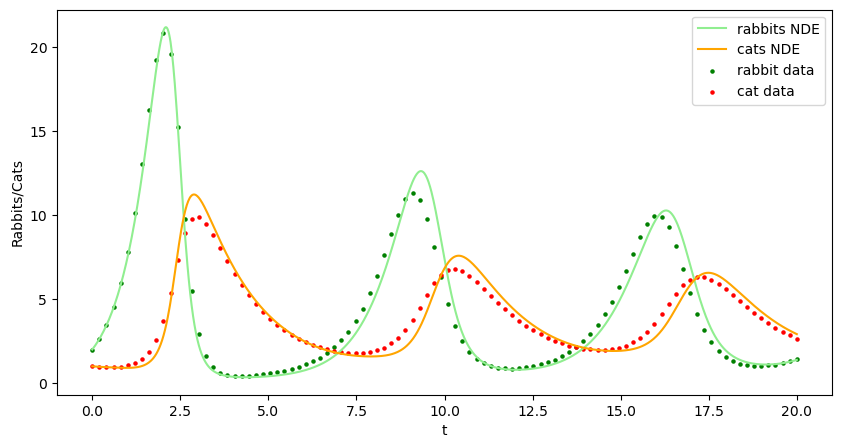

In [62]:
plt.figure(figsize = (10,5))
#plt.plot(t_plot, sol[:,0], label = "rabbits", color = "green")
#plt.plot(t_plot, sol[:,1], label = "cats", color = "red")
plt.plot(t_plot, sol_NDE[:, 0], label = "rabbits NDE", color = "lightgreen")
plt.plot(t_plot, sol_NDE[:, 1], label = "cats NDE", color = "orange")
plt.scatter(t_data, sol_true[:,0], label = "rabbit data", color = "green", s = 5)
plt.scatter(t_data, sol_true[:,1], label = "cat data", color = "red", s = 5)
plt.xlabel("t")
plt.ylabel("Rabbits/Cats")
plt.legend()
plt.show()